In [67]:
#| echo: false
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 

import numpy as np
import pandas as pd

---
title: "Picovoice Screening Questions - ROC Curve"
author: "Zhang-Houle Germain"
highlight-style: pygments
toc: true
number-sections: true
format: 
  html: 
    html-math-method: katex
    code-fold: true
---

## Preface {.unnumbered .unlisted}

Throughout this article, we'll be introducing the concept of the ROC curve using a combination of written text and code snippets. The code snippets are not necessary but serve as a tool to facilitate understanding. 

In addition, we'll explore the decision-making process behind selecting a classification threshold and briefly discuss the implications of the area under the curve (AUC) for varying receiver operating characteristic (ROC) curves.

It should be noted that this article uses a modified version of the digits dataset provided by sci-kit learn.

Our version of the digits dataset converts the target lists for the classification task to boolean values, such that they are only valid for the digit "3" and invalid for all other digits -- restricting our data to two classes.

In [68]:
# Loading and processing digits dataset
hw_digits = load_digits()
n_samples = len(hw_digits.images)
data = hw_digits.images.reshape((n_samples, -1))

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, hw_digits.target, test_size=0.5, shuffle=False
)

# Sample data given as n digits[0..9], however, we wish to classify based on the trueness of 3
y_train_mod = (y_train == 3) 
y_test_mod = (y_test == 3)

## Receiver Operating Characteristic (ROC) Curve {.unnumbered} 
The <strong>ROC</strong> curve is a commonly used performance measure of a classification model. 

It visualizes the trade-off between the <strong>true-positive rate (sensitivity)</strong> and the <strong>false-positive rate (1 - specificity)</strong>.

True-Positive Rate (sensitivity):

$TP/(TP+FP)$

False-Positive Rate (1-specificity):

$FP/(FP+TN)$

The plot below is an example of a ROC curve produced using our version of the digits dataset.


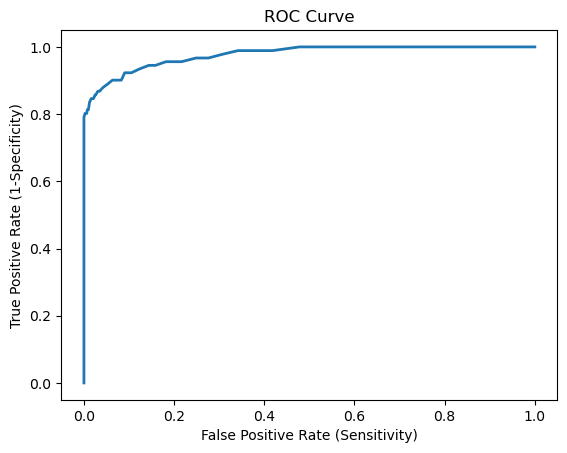

In [69]:
# Create classifier: RF 
clf = RandomForestClassifier() 

# Learn the truth value of digits from training partition 
clf.fit(X_train, y_train_mod)

# Probability of truth value of the digit from the test partition in the test subset
clf_pred = clf.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test_mod, clf_pred[:,1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, linewidth=2)
plt.xlabel("False Positive Rate (Sensitivity)")
plt.ylabel("True Positive Rate (1-Specificity)")

plt.show()

## The Trade-off Between Sensitivity and Specificity {.unnumbered}
For a given test, we have a classification <strong>threshold</strong> for which any items above the threshold are part of the positive class and any items below the threshold are part of the negative class.

As mentioned previously, the ROC curve visualizes how sensitivity and specificity are negatively correlated to each other with respect to these changes in the classification threshold.

Consider the plots of our digits datasets with varying thresholds below:

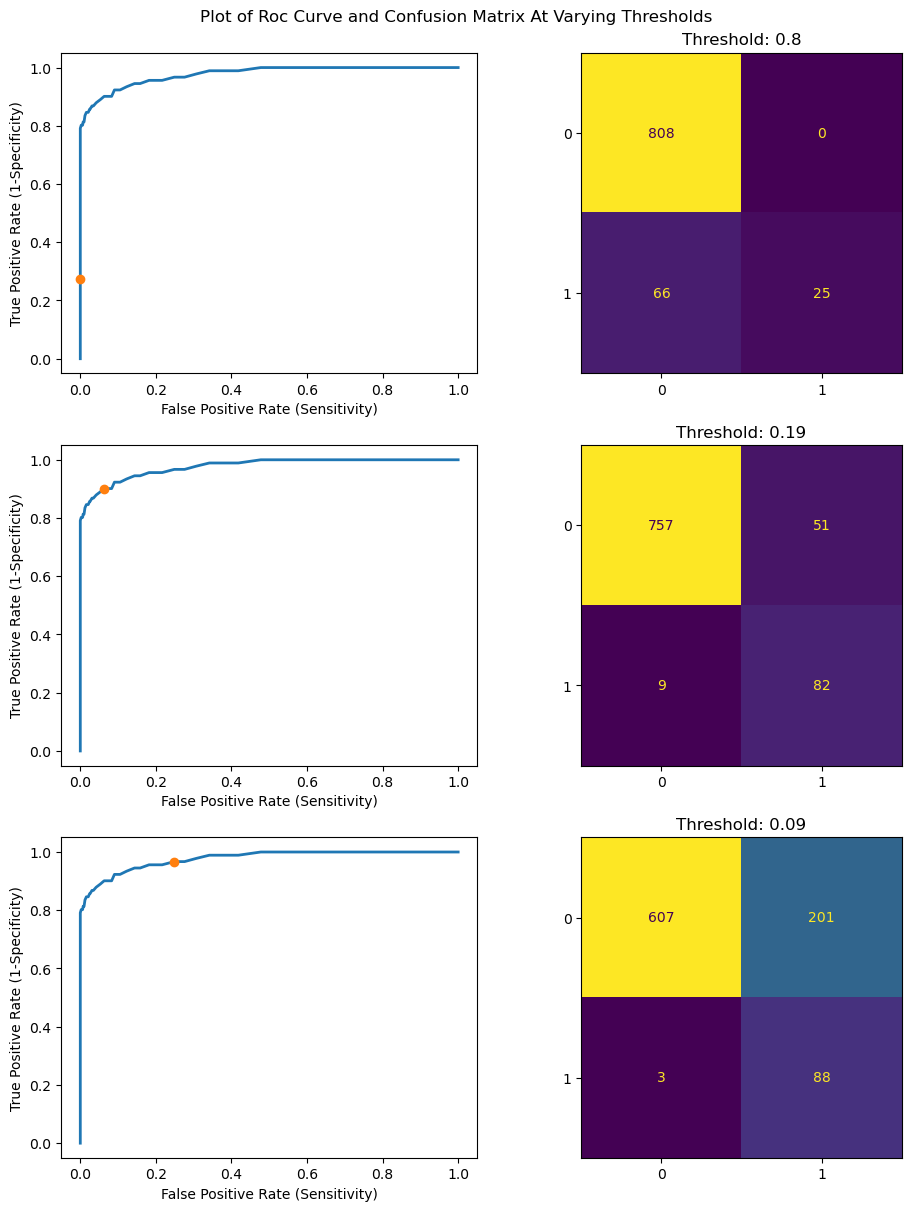

In [70]:
diff_fpr_tpr = tpr - fpr
index_h = (thresholds <= 0.8).argmax() # max index at cut off 0.8 
index_m = (diff_fpr_tpr).argmax() # index corresponding to the point minimizing TPR - FPR
index_l = (thresholds >= 0.1).argmin() # min index at cut off 0.1
threshold_index = [index_h,index_m,index_l] 

f, axes = plt.subplots(3, 2, figsize=(9, 12), constrained_layout=True)
f.suptitle("Plot of Roc Curve and Confusion Matrix At Varying Thresholds")
for i in range(3):
    cf_matrix = metrics.confusion_matrix(y_test_mod, (clf_pred[:,1] >= thresholds[threshold_index[i]]).astype("int"))
    cf_disp = metrics.ConfusionMatrixDisplay(cf_matrix)
    cf_disp.plot(ax=axes[i][1])
    cf_disp.im_.colorbar.remove()
    out_str = str(thresholds[threshold_index[i]])
    axes[i][1].set_xlabel("")
    axes[i][1].set_ylabel("")

    axes[i,1].set_title("Threshold: " + out_str)
    axes[i,0].plot(fpr, tpr, linewidth=2, label="ROC curve")
    axes[i,0].plot(fpr[threshold_index[i]],tpr[threshold_index[i]],"o")
    axes[i,0].set(xlabel="False Positive Rate (Sensitivity)", ylabel="True Positive Rate (1-Specificity)")

plt.show()

As we increase the threshold, sensitivity decreases while specificity increases.

Conversely, as we lower the threshold, specificity increases while sensitivity decreases.

## Threshold Selection {.unnumbered}
We observed the effects of changes in threshold on both sensitivity and specificity using the ROC curve in the previous example.

However, when it comes to selecting a threshold, we must consider the classification model on a case-by-case basis.

To select the ideal classification threshold, it's crucial to consider the context of the classification model. 

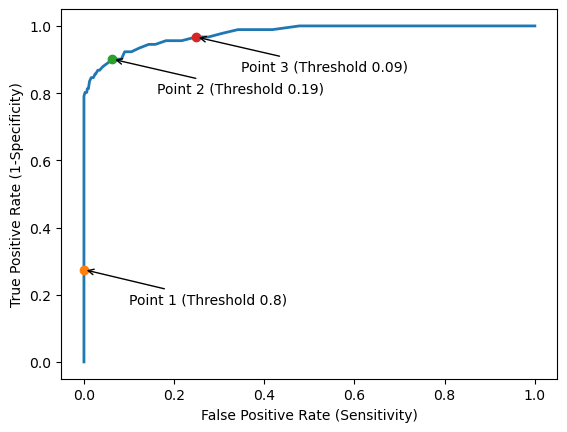

In [71]:
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.xlabel("False Positive Rate (Sensitivity)")
plt.ylabel("True Positive Rate (1-Specificity)")
for i in range(3):
    plt.plot(fpr[threshold_index[i]],tpr[threshold_index[i]],"o")
    plt.annotate("Point "+str(i+1)+" (Threshold "+str(thresholds[threshold_index[i]])+")",(fpr[threshold_index[i]],tpr[threshold_index[i]]),
                xytext=(fpr[threshold_index[i]]+0.1,tpr[threshold_index[i]]-0.1),arrowprops=dict(arrowstyle="->"))


plt.show()

Now, what would the ideal classification threshold be for our model?

While there is no clear-cut answer, in general, the choice of classification threshold depends on the importance of TPR and FPR within its context.

For example, when doing illness detection, we would aim to maximize the number of true positives, and as a result, we'd select a lower threshold, such as point 3. 

On the other hand, for a spam filter, we aim to minimize the number of false negatives and select a higher threshold, such as point 1. 

For our classifier, there are few external limitations as our goal is to identify the digit "3" from a set of digits, and as a result, we may choose a balance of those two concerns. One such point is point 2, which maximizes the difference between TPR and FPR.

## Performance Implications of the ROC Curve {.unnumbered}

Similarly to how the ROC curve gives a quick visual representation of the relationship between TPR and FPR, it also helps us understand the classifier's accuracy.

One way to compare classifiers is to calculate the area under the curve (AUC).

The plot generated below compares our classifier with a random and ideal classifier.

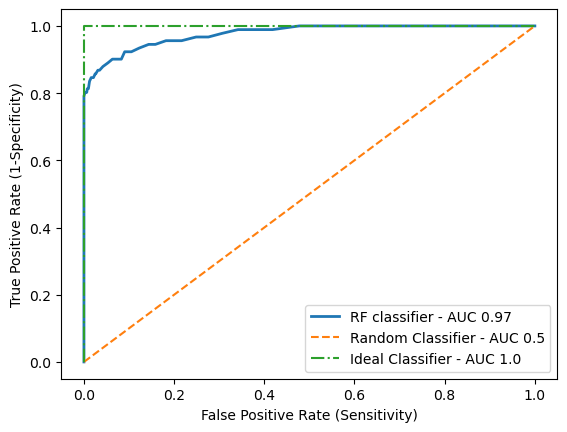

In [72]:
plt.plot(fpr, tpr, linewidth=2, label=("RF classifier - AUC "+str(metrics.auc(fpr,tpr))[:4]))
plt.plot([0, 1], [0, 1], "--", label="Random Classifier - AUC 0.5")
plt.plot([0,0, 1], [0,1, 1],"-.", label="Ideal Classifier - AUC 1.0")
plt.xlabel("False Positive Rate (Sensitivity)")
plt.ylabel("True Positive Rate (1-Specificity)")

plt.legend()
plt.show()

When it comes to the random classifier, the model is incapable of discriminating between the two classes. As a result, we have a curve with equal TPR and FPR at all thresholds and AUC equal to 0.5.

On the other hand, our ideal classifier can distinguish between the positive and negative classes without fault, and we have an AUC equal to 1.

However, in practice, our models lay between these two extremes as we introduce false positive and negative errors. 

## Multiclass Receiver Operating Characteristic (ROC) Curve {.unnumbered}

Throughout this article, we have worked with a binary classifier that distinguishes between two classes -- "the digit 3" and "digits that aren't 3."

If we wanted to extend our functionality into a multiclass classifier and evaluate the quality using an ROC curve, we would have to "binarize" our output using either the One-vs-Rest scheme or the One-vs-One scheme.
